# Step 1: Imports

In [ ]:
import pandas as pd
import numpy as np
import re
import os
from google.colab import files


In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import sklearn

print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", sns.__version__)
print("scikit-learn:", sklearn.__version__)


pandas: 2.2.2
numpy: 2.0.2
matplotlib: 3.10.0
seaborn: 0.13.2
scikit-learn: 1.6.1


# Step 2: Upload CSV file

In [ ]:
uploaded = files.upload()
raw_file = list(uploaded.keys())[0]
print("✅ Uploaded file:", raw_file)


Saving Survey_Raw.csv to Survey_Raw.csv
✅ Uploaded file: Survey_Raw.csv


# Step 3: Load CSV into DataFrame

In [ ]:
df_raw = pd.read_csv(raw_file, encoding='utf-8')
print("Original columns:", df_raw.columns.tolist())
print("Rows:", len(df_raw))


Original columns: ['Timestamp', 'Your Email ID', 'Your Full Name', 'Your Institution Name', 'Which class are you currently enrolled in? ', 'In which division are you currently studying? ', '1. How many hours do you study in  week?', '2.  On average, how many days do you attend school/college per week? ', '3. How actively are your parents involved in your academic activities? ', '4. How easily do you have access to educational resources (books, internet, study materials)? ', '5. Which educational resources do you lack? ', '6. On average, how many hours of sleep do you get per night?  ', '7. How often do you participate in extracurricular activities (sports, clubs, arts, volunteering, etc.)?  ', '8. How would you rate the quality of teaching at your school/college?  ', '9. What type of school/college do you attend?  ', '10. Do you have any physical disabilities that affect your daily activities or education?  ', 'If yes, explain it.', '11. How far is your home from your school/college?  

# Step 4: Remove PII Columns

In [ ]:
pii_cols = ["Timestamp", "Your Email ID", "Your Full Name", "Your Institution Name"]
df = df_raw.drop(columns=[c for c in pii_cols if c in df_raw.columns], errors='ignore')


# Step 5: Rename Columns to Canonical Schema

In [ ]:
print("Original column names:")
for i, col in enumerate(df.columns):
    print(f"{i}: '{col}'")


Original column names:
0: 'Which class are you currently enrolled in? '
1: 'In which division are you currently studying? '
2: '1. How many hours do you study in  week?'
3: '2.  On average, how many days do you attend school/college per week? '
4: '3. How actively are your parents involved in your academic activities? '
5: '4. How easily do you have access to educational resources (books, internet, study materials)? '
6: '5. Which educational resources do you lack? '
7: '6. On average, how many hours of sleep do you get per night?  '
8: '7. How often do you participate in extracurricular activities (sports, clubs, arts, volunteering, etc.)?  '
9: '8. How would you rate the quality of teaching at your school/college?  '
10: '9. What type of school/college do you attend?  '
11: '10. Do you have any physical disabilities that affect your daily activities or education?  '
12: 'If yes, explain it.'
13: '11. How far is your home from your school/college?  '
14: '12. What is your gender?  '
1

In [ ]:
rename_map = {
    "Which class are you currently enrolled in? ": "enrolled_in_class",
    "In which division are you currently studying? ": "division",
    "1. How many hours do you study in  week?": "study_hours",
    "2.  On average, how many days do you attend school/college per week? ": "weekly_attendance",
    "3. How actively are your parents involved in your academic activities? ": "parental_involvement",
    "4. How easily do you have access to educational resources (books, internet, study materials)? ": "resource_access",
    "5. Which educational resources do you lack? ": "missing_resources",
    "6. On average, how many hours of sleep do you get per night?  ": "sleep_hours",
    "7. How often do you participate in extracurricular activities (sports, clubs, arts, volunteering, etc.)?  ": "extracurricular_activity",
    "8. How would you rate the quality of teaching at your school/college?  ": "teaching_quality",
    "9. What type of school/college do you attend?  ": "institution_type",
    "10. Do you have any physical disabilities that affect your daily activities or education?  ": "disability_status",
    "If yes, explain it.": "disability_explanation",
    "11. How far is your home from your school/college?  ": "commuting_distance",
    "12. What is your gender?  ": "gender",
    "13. What is your family's monthly income?  ": "family_income",
    "14. On average, how many hours per week do you engage in physical activities (sports, exercise, walking, etc.)?  ": "physical_activity_hours",
    "15. On average, how many hours per week do you spend on private tutoring sessions outside of regular school or college hours? ": "tutoring_hours",
    "16. What were your grades like in the last three years? ": "gpa_last_year",  # instead of grades_raw
    "Your 2nd last year and GPA ? (e.g. 2023 - 4.90)": "gpa_2nd_last_year",
    "Your 3rd last year and GPA ? (2022 - 4.81)": "gpa_3rd_last_year"
}

df.rename(columns=rename_map, inplace=True)


# Step 6: GPA Parsing & Standardization

In [ ]:
def fix_missing_gpa_years(df):
    year_map = {"gpa_last_year": "2024", "gpa_2nd_last_year": "2023", "gpa_3rd_last_year": "2022"}

    for col, year in year_map.items():
        if col in df.columns:
            def fix_entry(entry):
                if pd.isna(entry) or str(entry).strip() == "":
                    return np.nan
                entry_str = str(entry).strip()
                # Already has year
                if "-" in entry_str:
                    parts = entry_str.split('-', 1)
                    try:
                        gpa_float = float(parts[1].strip())
                        return f"{parts[0].strip()} - {gpa_float:.2f}"
                    except:
                        return entry_str
                # Pure numeric GPA
                try:
                    gpa_float = float(entry_str.replace(',', '.'))
                    return f"{year} - {gpa_float:.2f}"
                except:
                    return np.nan
            df[col] = df[col].apply(fix_entry)
    return df

df = fix_missing_gpa_years(df)


# Step 7: Preprocess Enrolled Class

In [ ]:
def preprocess_enrolled_class(df):
    text_to_number = {
        'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'seven': 7, 'eight': 8,
        'nine': 9, 'ten': 10, 'eleven': 11, 'twelve': 12
    }
    roman_to_number = {'i': 1, 'ii': 2, 'iii': 3, 'iv': 4, 'v': 5, 'vi': 6, 'vii': 7, 'viii': 8, 'ix': 9, 'x': 10, 'xi': 11, 'xii': 12}

    def convert_class_value(value):
        if pd.isna(value) or str(value).strip() == "":
            return np.nan
        v = str(value).lower().strip()
        if any(k in v for k in ['inter', 'hsc']):
            return 11 if any(k in v for k in ['1st','i','first']) else 12
        if any(k in v for k in ['ssc','10th','matric']):
            return 10
        for text, num in text_to_number.items():
            if text in v: return num
        for roman, num in roman_to_number.items():
            if roman in v: return num
        try:
            num = int(re.search(r'\d+', v).group())
            if 1 <= num <= 12: return num
        except: return np.nan
        return np.nan

    df['enrolled_in_class'] = df['enrolled_in_class'].apply(convert_class_value)
    return df

df = preprocess_enrolled_class(df)


# Step 8: Extract GPA Numeric Values

In [ ]:
def extract_gpa_value(entry):
    if pd.isna(entry) or str(entry).strip() == "":
        return np.nan
    entry_str = str(entry)
    try:
        numeric_match = re.search(r'(\d+\.?\d*)$', entry_str)
        return float(numeric_match.group(1)) if numeric_match else np.nan
    except:
        return np.nan

for col in ["gpa_last_year","gpa_2nd_last_year","gpa_3rd_last_year"]:
    df[col+"_value"] = df[col].apply(extract_gpa_value)


# Step 9: Drop Unnecessary Columns

In [ ]:
df.drop(columns=['division'], errors='ignore', inplace=True)


# Step 10: Range Validation & Flagging

In [ ]:
ranges = {
    "gpa_last_year_value": (0,5.0),
    "gpa_2nd_last_year_value": (0,5.0),
    "gpa_3rd_last_year_value": (0,5.0),
    "enrolled_in_class": (1,12)
}

flags = []
for col,(low,high) in ranges.items():
    if col in df.columns:
        mask = df[col].notna() & ((df[col]<low) | (df[col]>high))
        for idx in df[mask].index:
            flags.append({"row": idx, "column": col, "value": df.loc[idx,col]})
        df.loc[mask,col] = np.nan

flagged_df = pd.DataFrame(flags)


# Step 11: Remove Rows with Flagged Issues

In [ ]:
if not flagged_df.empty:
    rows_to_drop = flagged_df['row'].unique()
    df = df.drop(index=rows_to_drop).reset_index(drop=True)

# Remove temporary GPA numeric columns
df.drop(columns=[c for c in df.columns if '_value' in c], inplace=True)


# Step 12: Clean and Normalize Gender Column

In [ ]:
# Clean and normalize gender column
df['gender'] = df['gender'].str.strip().str.title()  # Remove extra spaces, capitalize consistently

# Verify the fix
print(df['gender'].value_counts())


gender
Male      997
Female    507
Name: count, dtype: int64


# Step 13: Save Preprocessed Data

In [ ]:
output_filename = 'preprocessed_student_data.csv'
df.to_csv(output_filename,index=False)
print(f"✅ Preprocessed data saved: {output_filename}")
print(f"📊 Shape: {df.shape}")
print(f"💾 File size: {df.memory_usage(deep=True).sum()/1024/1024:.2f} MB")


✅ Preprocessed data saved: preprocessed_student_data.csv
📊 Shape: (1504, 20)
💾 File size: 1.68 MB


# Step 14: Summary Statistics

In [ ]:
# --- SUMMARY STATISTICS ---

# 1. Show overall shape
print("Final Dataset Shape:", df.shape)

# 2. Numerical summary
numeric_summary = df.select_dtypes(include=[np.number]).describe().T
print("\n Numerical Summary (Mean, Std, Min, Max):")
display(numeric_summary)

# 3. Categorical summary (frequency distribution)
categorical_summary = {}
for col in df.select_dtypes(exclude=[np.number]).columns:
    value_counts = df[col].value_counts(dropna=False)
    categorical_summary[col] = value_counts

print("\n Categorical Summary (Top Frequencies):")
for col, vc in categorical_summary.items():
    print(f"\n {col}:")
    print(vc.head(10))  # Show top 10 categories

# 4. Missing value count
missing_summary = df.isnull().sum()
print("\n Missing Values per Column:")
print(missing_summary[missing_summary > 0])

# 5. Save summary stats to CSV for paper
numeric_summary.to_csv("numeric_summary.csv")
print("Saved numerical summary as numeric_summary.csv")


Final Dataset Shape: (1504, 20)

 Numerical Summary (Mean, Std, Min, Max):


,count,mean,std,min,25%,50%,75%,max
enrolled_in_class,1504.0,9.844415,1.44161,1.0,9.0,10.0,11.0,12.0



 Categorical Summary (Top Frequencies):

 study_hours:
study_hours
11-20 hours          705
21-30 hours          350
5-10 hours           338
less than 5 hours    111
Name: count, dtype: int64

 weekly_attendance:
weekly_attendance
3-4 days    766
5-6 days    377
1-2 days    361
Name: count, dtype: int64

 parental_involvement:
parental_involvement
Moderately involved       536
Highly involved           389
Slightly involved         299
Very actively involved    156
Not involved at all       124
Name: count, dtype: int64

 resource_access:
resource_access
Medium    680
Low       478
High      346
Name: count, dtype: int64

 missing_resources:
missing_resources
Internet access, Online courses                     214
Study materials, Library access                     204
Study materials, Online courses                     121
Internet access, Library access                      75
Internet access, Study materials                     70
Internet access, Study materials, Online courses  

In [ ]:
# --- CLASS DISTRIBUTION ---

if 'enrolled_in_class' in df.columns:
    class_distribution = df['enrolled_in_class'].value_counts(dropna=False).sort_index()
    print("\n Class Distribution:")
    print(class_distribution)

    # Convert to percentage
    class_percentage = (class_distribution / len(df) * 100).round(2)
    class_dist_df = pd.DataFrame({"Count": class_distribution, "Percentage": class_percentage})
    class_dist_df.index.name = "Class"
    display(class_dist_df)

    # Save to CSV for paper
    class_dist_df.to_csv("class_distribution.csv")
    print("Saved class distribution as class_distribution.csv")



 Class Distribution:
enrolled_in_class
1.0       1
7.0       4
8.0     348
9.0     313
10.0    313
11.0    254
12.0    271
Name: count, dtype: int64


,Count,Percentage
Class,,
1.0,1,0.07
7.0,4,0.27
8.0,348,23.14
9.0,313,20.81
10.0,313,20.81
11.0,254,16.89
12.0,271,18.02


Saved class distribution as class_distribution.csv


# Step 15: Distribution Plots


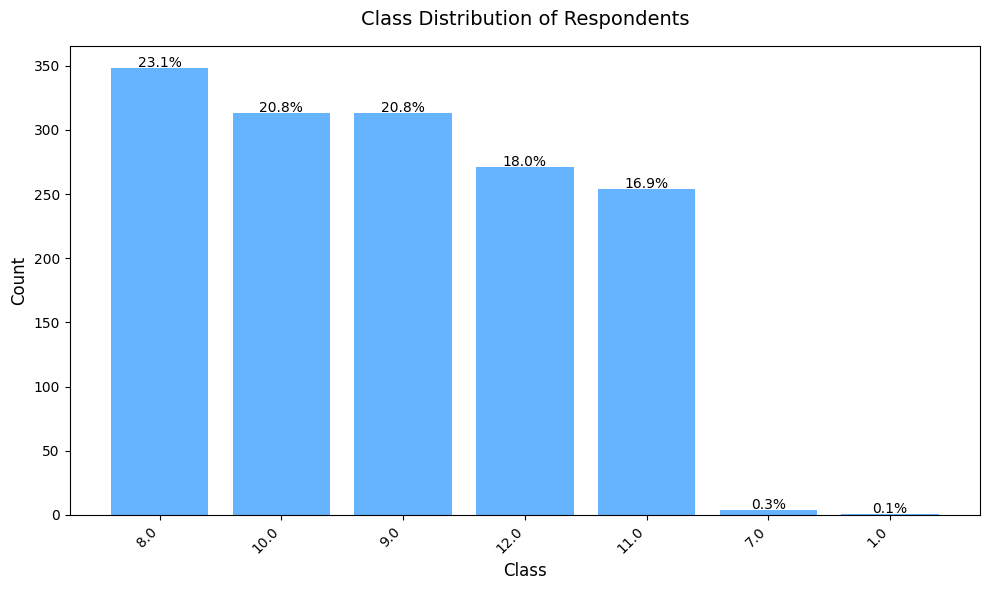

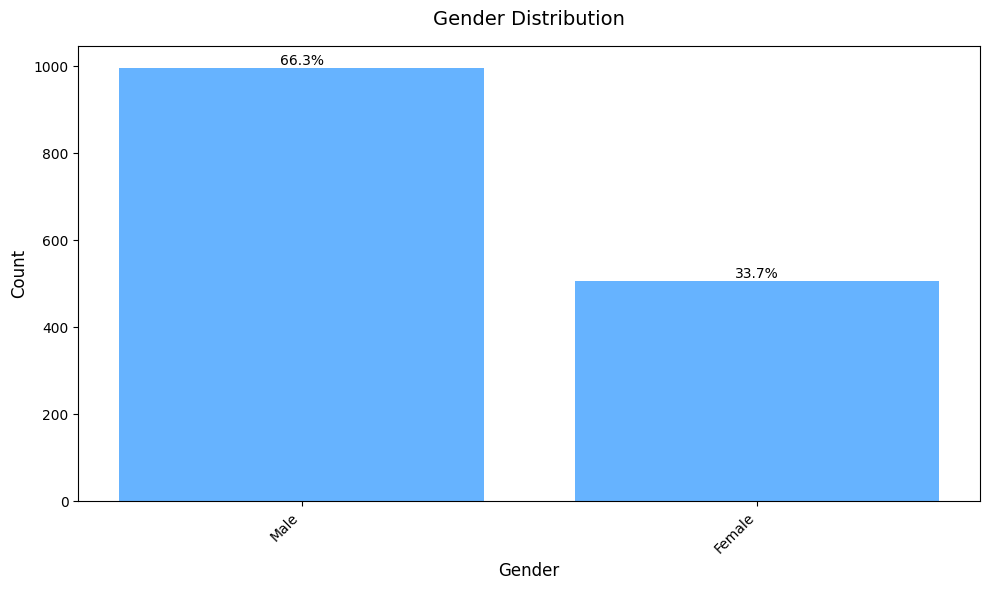

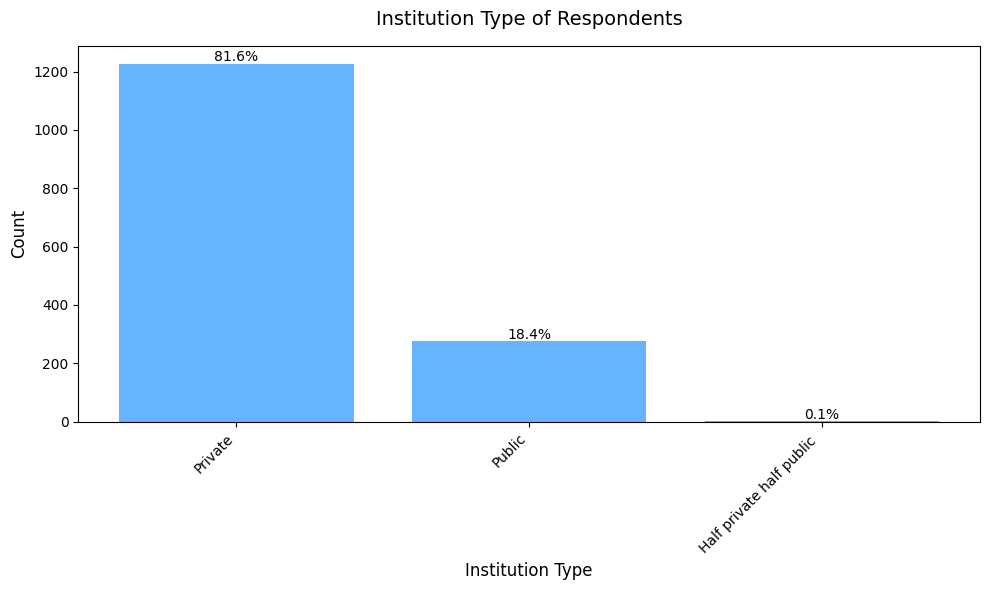

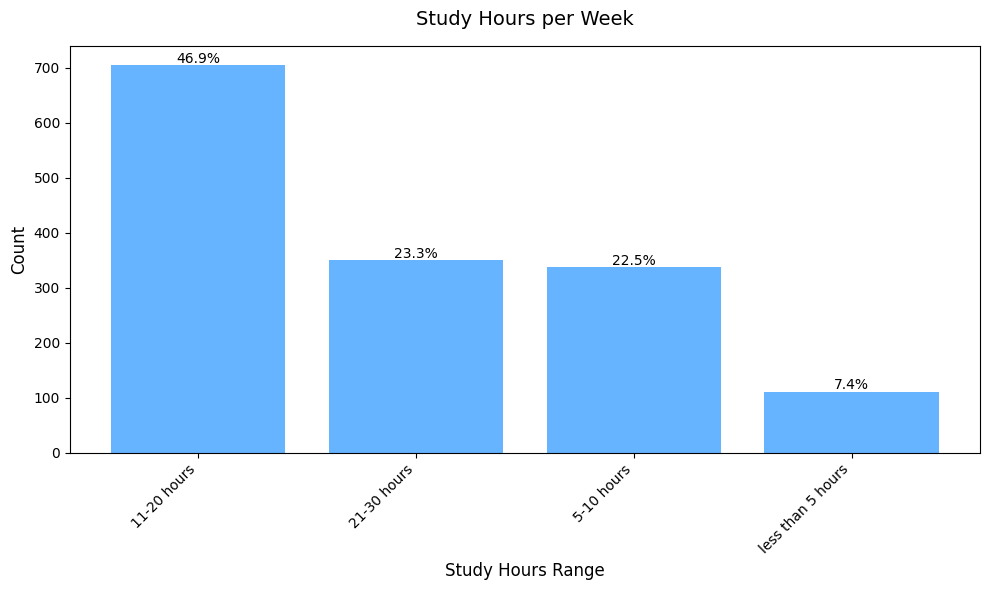

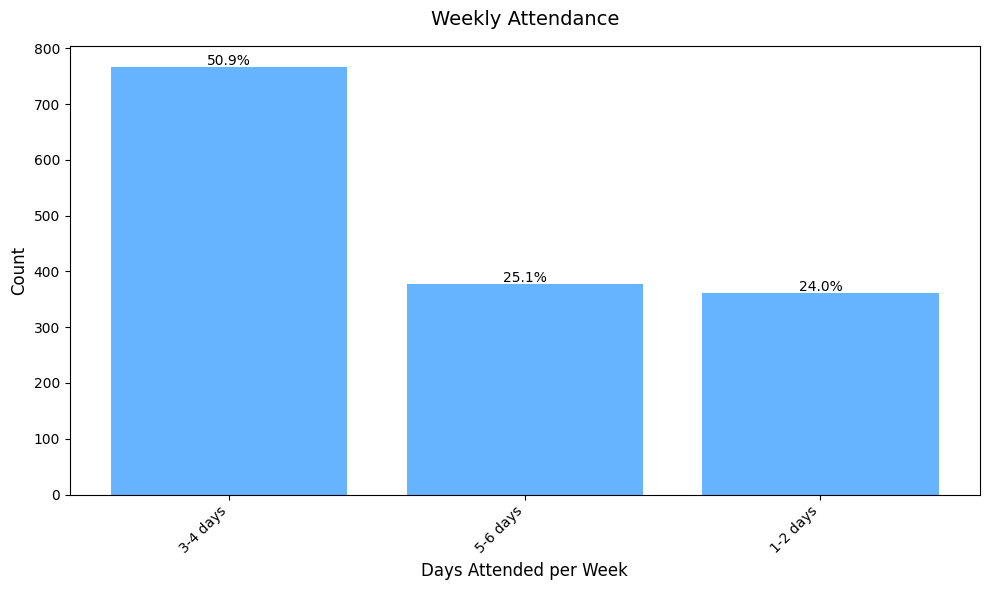

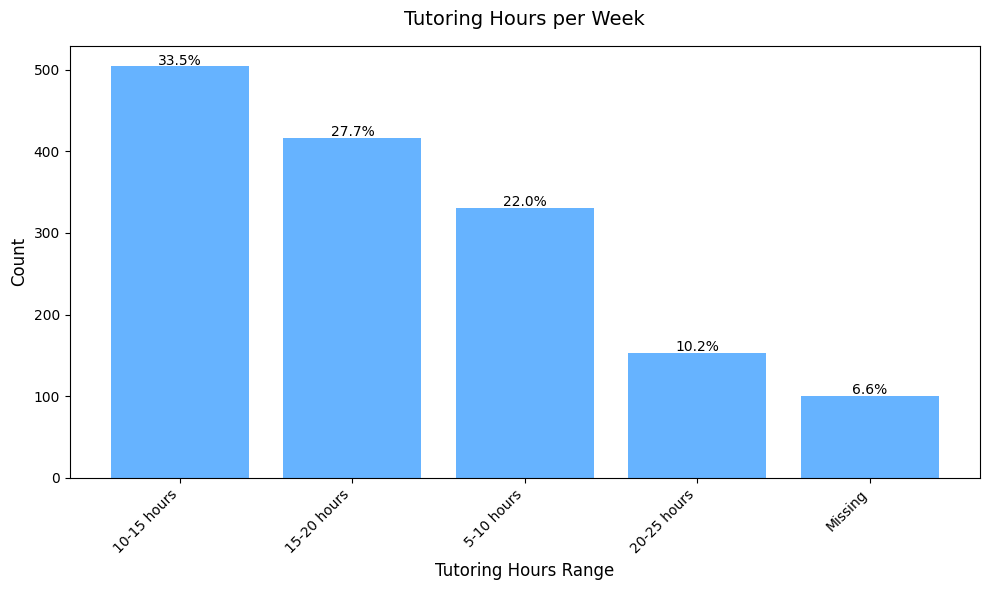

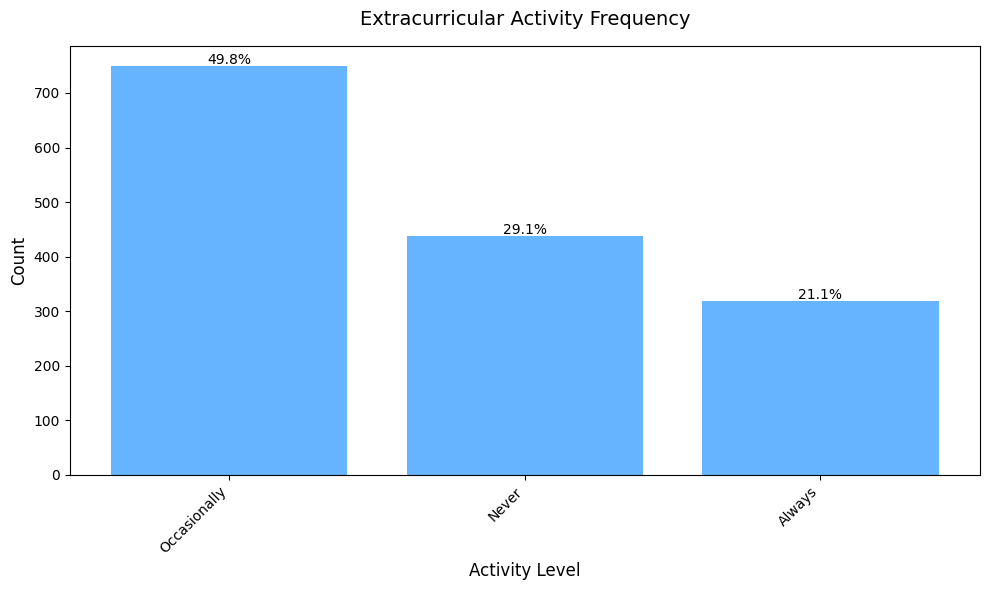

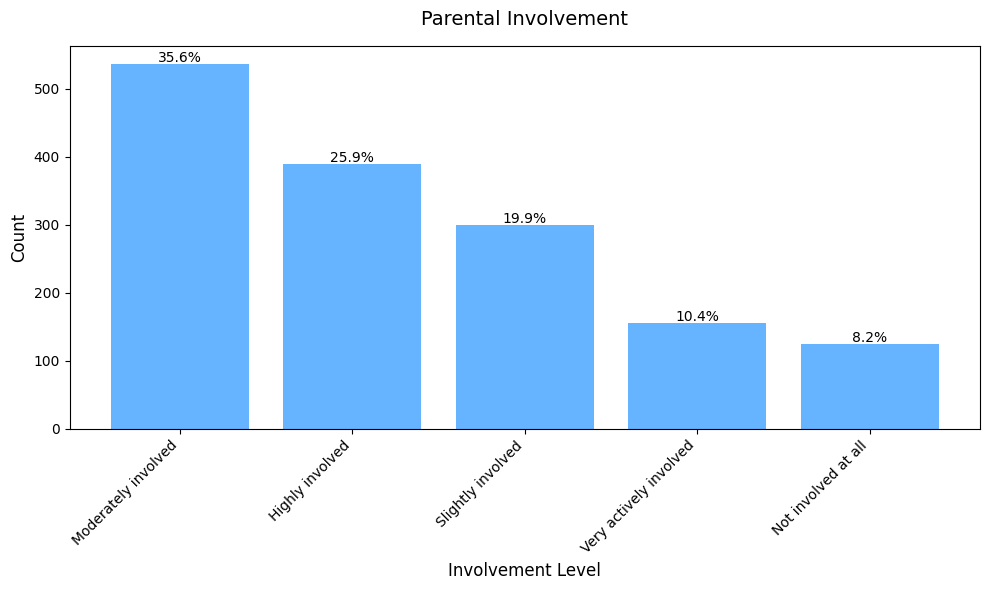

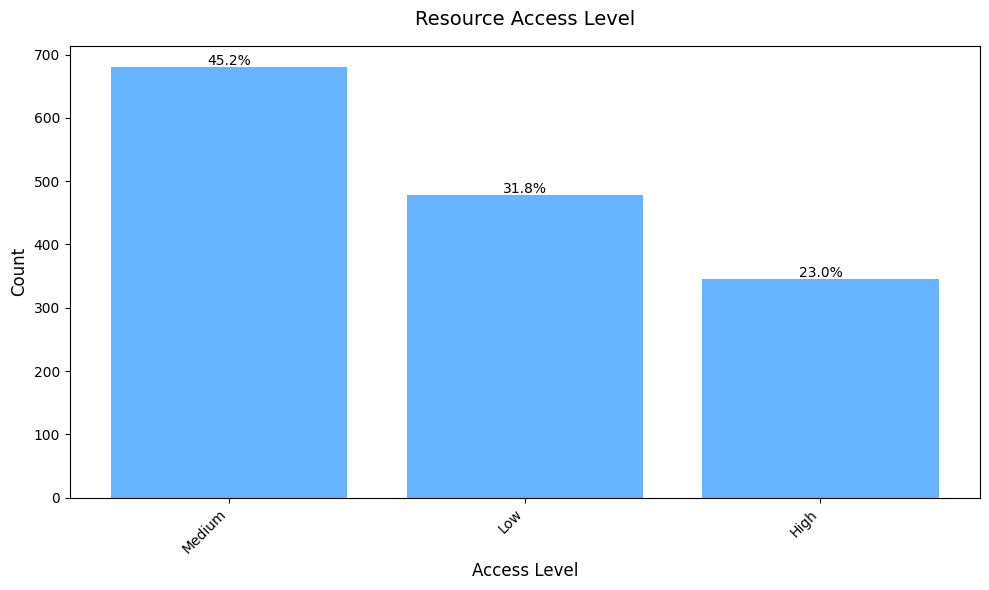

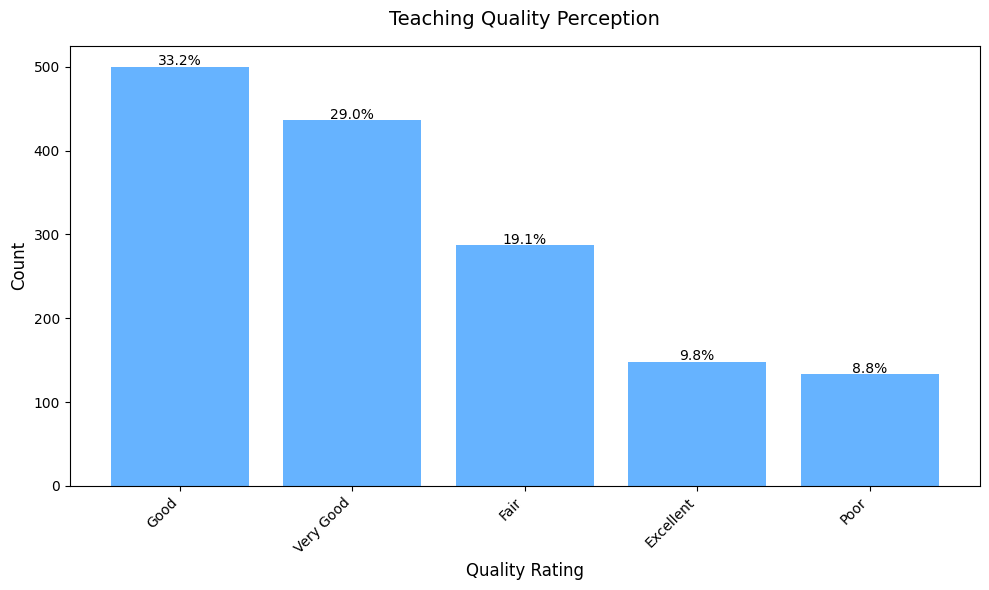

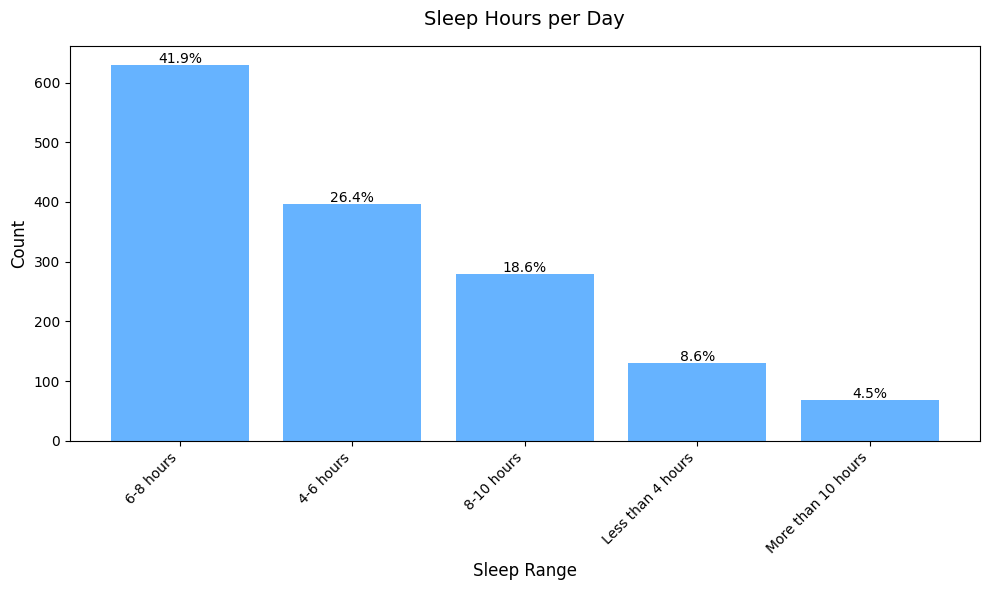

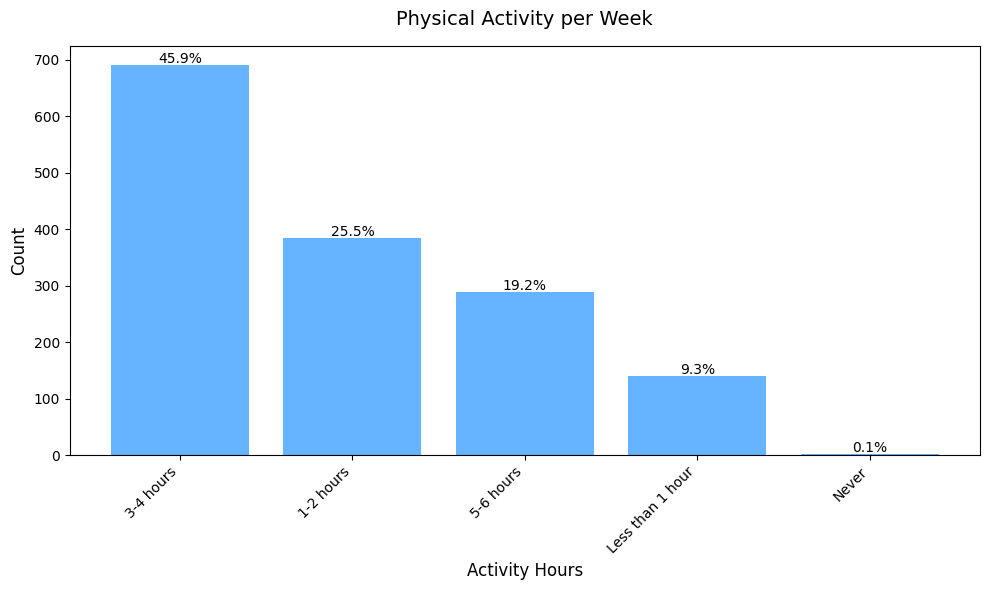

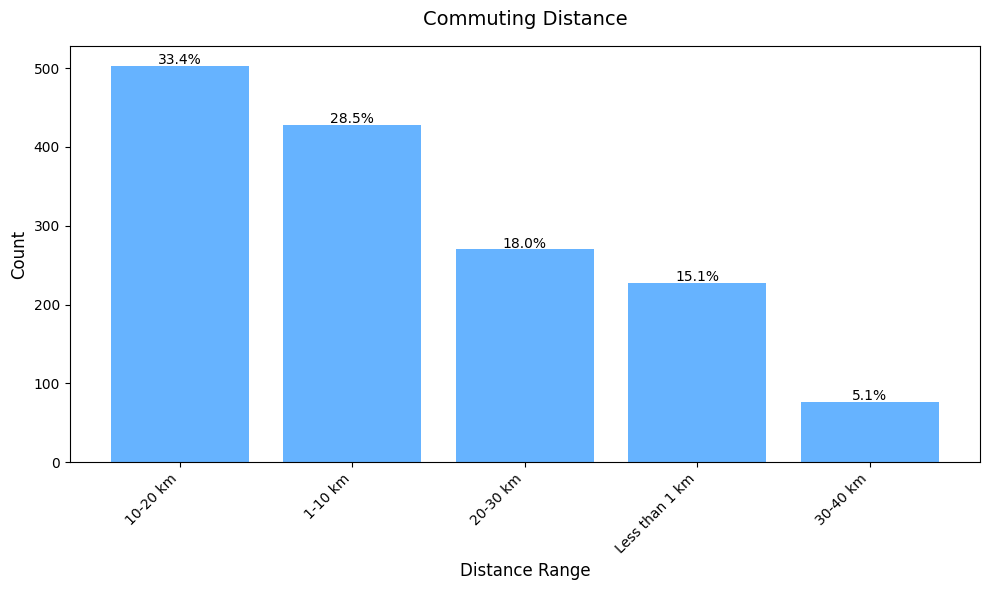

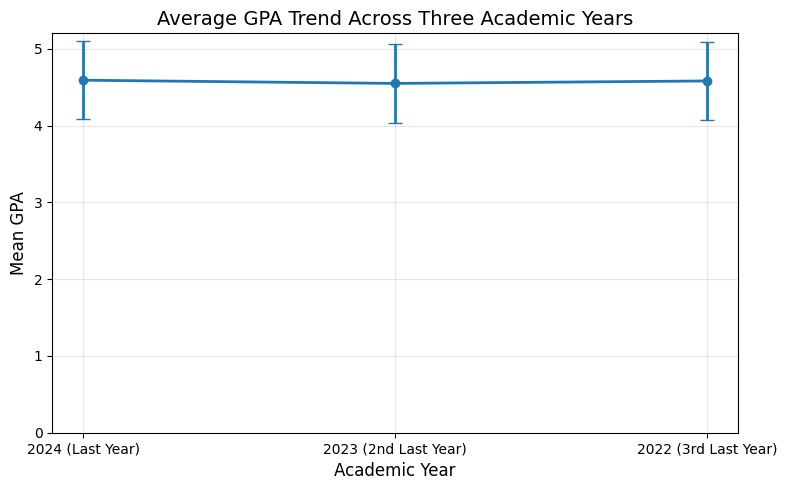

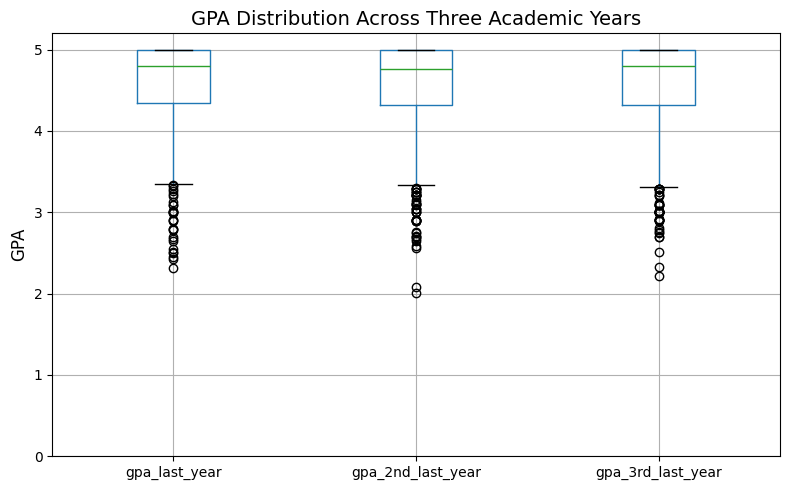

In [ ]:
# ===============================
# Descriptive Plots for Dataset
# ===============================
import matplotlib.pyplot as plt

# --- Helper function for categorical distributions ---
def plot_categorical_distribution(series, title, xlabel, filename, top_n=None):
    counts = series.value_counts()
    if top_n:
        counts = counts.head(top_n)

    plt.figure(figsize=(10, 6))  # increased figure size
    bars = plt.bar(counts.index.astype(str), counts.values, color='#66b3ff')

    # Add percentages on top of bars
    total = counts.sum()
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height - total*0.001,  # slightly above bar
            f'{(height/total*100):.1f}%',
            ha='center', va='bottom', fontsize=10
        )

    plt.title(title, fontsize=14, pad=15)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    plt.close()


# --- Respondent Profile ---
class_dist_df = plot_categorical_distribution(
    df['enrolled_in_class'],
    title="Class Distribution of Respondents",
    xlabel="Class",
    filename="class_distribution.png"
)

gender_dist = plot_categorical_distribution(
    df['gender'],
    title="Gender Distribution",
    xlabel="Gender",
    filename="gender_distribution.png"
)

institution_type_dist = plot_categorical_distribution(
    df['institution_type'],
    title="Institution Type of Respondents",
    xlabel="Institution Type",
    filename="institution_type_distribution.png"
)

# --- Study Behavior ---
study_hours_dist = plot_categorical_distribution(
    df['study_hours'],
    title="Study Hours per Week",
    xlabel="Study Hours Range",
    filename="study_hours_distribution.png"
)

weekly_attendance_dist = plot_categorical_distribution(
    df['weekly_attendance'],
    title="Weekly Attendance",
    xlabel="Days Attended per Week",
    filename="weekly_attendance_distribution.png"
)

tutoring_hours_dist = plot_categorical_distribution(
    df['tutoring_hours'].fillna("Missing"),  # Handle NaN
    title="Tutoring Hours per Week",
    xlabel="Tutoring Hours Range",
    filename="tutoring_hours_distribution.png"
)

extracurricular_activity_dist = plot_categorical_distribution(
    df['extracurricular_activity'],
    title="Extracurricular Activity Frequency",
    xlabel="Activity Level",
    filename="extracurricular_activity_distribution.png"
)

# --- Learning Environment ---
parental_involvement_dist = plot_categorical_distribution(
    df['parental_involvement'],
    title="Parental Involvement",
    xlabel="Involvement Level",
    filename="parental_involvement_distribution.png"
)

resource_access_dist = plot_categorical_distribution(
    df['resource_access'],
    title="Resource Access Level",
    xlabel="Access Level",
    filename="resource_access_distribution.png"
)

teaching_quality_dist = plot_categorical_distribution(
    df['teaching_quality'],
    title="Teaching Quality Perception",
    xlabel="Quality Rating",
    filename="teaching_quality_distribution.png"
)

# --- Well-being ---
sleep_hours_dist = plot_categorical_distribution(
    df['sleep_hours'],
    title="Sleep Hours per Day",
    xlabel="Sleep Range",
    filename="sleep_hours_distribution.png"
)

physical_activity_dist = plot_categorical_distribution(
    df['physical_activity_hours'],
    title="Physical Activity per Week",
    xlabel="Activity Hours",
    filename="physical_activity_distribution.png"
)

commuting_distance_dist = plot_categorical_distribution(
    df['commuting_distance'],
    title="Commuting Distance",
    xlabel="Distance Range",
    filename="commuting_distance_distribution.png"
)

# --- Academic Performance (GPA Trend + Boxplot) ---
# Clean GPA columns to numeric
for col in ['gpa_last_year', 'gpa_2nd_last_year', 'gpa_3rd_last_year']:
    df[col] = df[col].astype(str).str.extract(r'(\d+\.\d+)')
    df[col] = df[col].astype(float)

# GPA Trend Line
gpa_means = df[['gpa_last_year', 'gpa_2nd_last_year', 'gpa_3rd_last_year']].mean()
gpa_stds = df[['gpa_last_year', 'gpa_2nd_last_year', 'gpa_3rd_last_year']].std()

plt.figure(figsize=(8, 5))
years = ['2024 (Last Year)', '2023 (2nd Last Year)', '2022 (3rd Last Year)']
plt.errorbar(years, gpa_means, yerr=gpa_stds, fmt='o-', capsize=5, linewidth=2)
plt.title("Average GPA Trend Across Three Academic Years", fontsize=14)
plt.xlabel("Academic Year", fontsize=12)
plt.ylabel("Mean GPA", fontsize=12)
plt.ylim(0, 5.2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("gpa_trend.png")
plt.show()
plt.close()

# GPA Boxplots
plt.figure(figsize=(8, 5))
df[['gpa_last_year', 'gpa_2nd_last_year', 'gpa_3rd_last_year']].boxplot()
plt.title("GPA Distribution Across Three Academic Years", fontsize=14)
plt.ylabel("GPA", fontsize=12)
plt.ylim(0, 5.2)
plt.tight_layout()
plt.savefig("gpa_boxplots.png")
plt.show()
plt.close()


# Step 16: Pie Charts


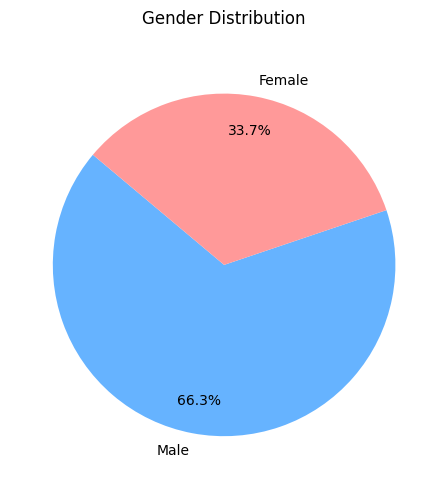

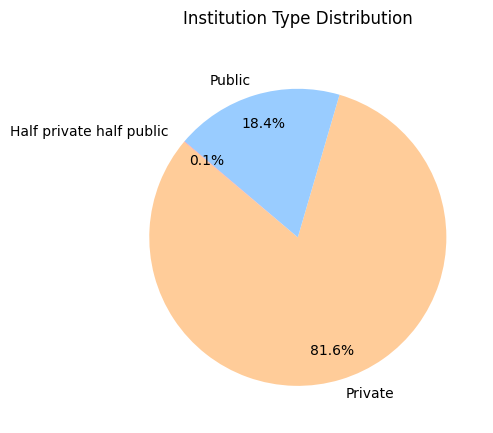

In [ ]:
# --- Gender Pie Chart ---
gender_counts = df['gender'].value_counts()
plt.figure(figsize=(5, 5))  # increased size for better fit
plt.pie(
    gender_counts,
    labels=gender_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=['#66b3ff', '#ff9999', '#99ff99'],
    pctdistance=0.8,  # move percentages slightly outward
    labeldistance=1.1  # move labels slightly outward
)
plt.title("Gender Distribution", pad=20)  # add padding for title
plt.tight_layout()
plt.savefig("gender_distribution_pie.png")
plt.show()
plt.close()

# --- Institution Type Pie Chart ---
institution_counts = df['institution_type'].value_counts()
plt.figure(figsize=(5, 5))  # increased size
plt.pie(
    institution_counts,
    labels=institution_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=['#ffcc99', '#99ccff', '#ff9999'],
    pctdistance=0.8,
    labeldistance=1.1
)
plt.title("Institution Type Distribution", pad=20)
plt.tight_layout()
plt.savefig("institution_type_distribution_pie.png")
plt.show()
plt.close()
